# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 2: сверточный классификатор.

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 8.5, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 5.22 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 10 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит познакомиться со сверточными сетями и их обучением для классификации изображений с использованием библиотеки PyTorch.


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

## 0. Загрузка данных

Работать мы будем с набором данных [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 представляет собой набор изображений 32х32 пикселя, разделенных на 10 классов.

![title](https://pytorch.org/tutorials/_images/cifar10.png)




Набор данных уже определен в <code>torchvision.datasets</code>, так что возьмем его оттуда.



In [4]:
def get_cifar10_data(batch_size, transform_train):
    torch.manual_seed(0)
    np.random.seed(0)

    transform_test = transforms.Compose(
        [transforms.ToTensor(),
         # Переводим цвета пикселей в отрезок [-1, 1]
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    # Загружаем данные
    trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                               download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)

    # В датасете определено разбиение только на train и test,
    # так что валидацию дополнительно выделяем из обучающей выборки
    train_idx, valid_idx = train_test_split(np.arange(len(trainvalset)), test_size=0.3,
                                            shuffle=True, random_state=0)
    trainset = torch.utils.data.Subset(trainvalset, train_idx)
    valset = torch.utils.data.Subset(trainvalset, valid_idx)

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                              shuffle=False, num_workers=2)

    return train_loader, val_loader, test_loader


In [5]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64,
                                                         transform_train=transform)

100%|██████████| 170M/170M [00:04<00:00, 41.2MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Посмотрим на изображения:

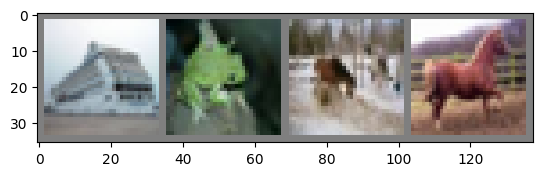

ship frog horse horse


In [6]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(*[classes[labels[i]] for i in range(4)])

## 1. Задание сверточной сети (3 балла)

Теперь нам нужно задать сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Используем сеть, основанную на одном блоке архитектуры ResNet.

<img src="https://i.ibb.co/2hg962h/basic-block.png" width="500"/>

__Указания:__

- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Выход блока сократите до размерности 32х4х4, применив average pooling.
- Для получения итоговых логитов, распрямите выход пулинга в вектор из 512 элементов, а затем пропустите его через линейный слой.

**Задание 1.1 (3 балла).**

Определите архитектуру сети соответственно схеме и указаниям выше.

Ключевые слова: <code>Conv2d</code>, <code>BatchNorm2d</code>, <code>AvgPool2d</code>.

In [7]:
n_classes = 10

class BasicBlockNet(nn.Module):
    def __init__(self):
        super().__init__()

        # <your code here>
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding='same'),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding='same'),
            nn.BatchNorm2d(num_features=32),
        )
        self.conv1x1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=1, padding='same')
        self.out_block = nn.Sequential(
            nn.ReLU(),
            nn.AvgPool2d(8),
            nn.Flatten(start_dim=1),
            nn.Linear(in_features=512, out_features=10)
        )

    def forward(self, x):
        out = self.encoder(x) + self.conv1x1(x)
        out = self.out_block(out)
        return out

In [8]:
net = BasicBlockNet()
net

BasicBlockNet(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv1x1): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1), padding=same)
  (out_block): Sequential(
    (0): ReLU()
    (1): AvgPool2d(kernel_size=8, stride=8, padding=0)
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Linear(in_features=512, out_features=10, bias=True)
  )
)

Проверим, что выход сети имеет корректную размерность:

In [9]:
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

Чтобы проводить вычисления на GPU, в PyTorch необходимо руками перекладывать объекты, с которыми вы хотите проводить вычисления, на графический ускоритель. Это делается следующим образрм:

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [11]:
net = net.to(device)

Подключение GPU в google.colab:

**Среда выполнения** -> **Сменить среду выполнения** -> **Аппаратный ускоритель** -> **GPU**

## 2. Обучение и тестирование модели (3 балла)

**Задание 2.1 (2 балла).** Переходим к обучению модели. Заполните пропуски в функциях <code>test</code> и <code>train_epoch</code>. В качестве функции потерь будем использовать [кросс-энтропию](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html), а в качестве метрики качества accuracy.

In [12]:
def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()

    criterion = nn.CrossEntropyLoss()

    for data, target in loader:

        # <your code here>
        data = data.to(device)
        target = target.to(device)
        with torch.no_grad():
          logits = model(data)
          loss = criterion(logits, target)

        acc = (logits.argmax(dim=1) == target).sum() / data.shape[0]

        loss_log.append(loss.item())
        acc_log.append(acc.item())

    return np.mean(loss_log), np.mean(acc_log)

def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()

    criterion = nn.CrossEntropyLoss()

    for data, target in train_loader:
      data = data.to(device)
      target = target.to(device)

      optimizer.zero_grad()
      logits = model(data)
      loss = criterion(logits, target)
      loss.backward()
      optimizer.step()

      acc = (logits.argmax(dim=1) == target).sum() / data.shape[0]

      loss_log.append(loss.item())
      acc_log.append(acc.item())

    return loss_log, acc_log

def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)

        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")

        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

Запустим обучение модели. В качестве оптимизатора будем использовать стохастический градиентный спуск, который является де-факто стандартом в задачах компьютерного зрения (наравне с <code>Adam</code>).

__Замечание:__ Для достижения наилучшего качества в нашем случае потребуется обучать модель несколько сотен эпох. Однако в целях экономии вашего времени и сил, во всех экспериментах мы ограничимся 20 эпохами.

In [13]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

Epoch 0
 train loss: 1.4566026339801181, train acc: 0.4812042961608775
 val loss: 1.2043228598351174, val acc: 0.5747118795171697

Epoch 1
 train loss: 1.1390924196574543, train acc: 0.6026336837294333
 val loss: 1.1269090632174878, val acc: 0.6150044327086591

Epoch 2
 train loss: 1.0351295455936105, train acc: 0.6406698877458381
 val loss: 1.050078202815766, val acc: 0.6378989361702128

Epoch 3
 train loss: 0.9814138267550215, train acc: 0.658106718464351
 val loss: 1.0604195845888016, val acc: 0.6353723404255319

Epoch 4
 train loss: 0.9465176346533042, train acc: 0.6731808240060615
 val loss: 0.9814372252910695, val acc: 0.6600620569066799

Epoch 5
 train loss: 0.9224761915163323, train acc: 0.6772982502114402
 val loss: 0.9527681984799974, val acc: 0.6724955675449777

Epoch 6
 train loss: 0.8979060065811687, train acc: 0.688883357335706
 val loss: 1.0049283169685526, val acc: 0.6607047872340426

Epoch 7
 train loss: 0.8764582944853432, train acc: 0.6945228845807273
 val loss: 0.95

Посчитайте точность на тестовой выборке:

In [14]:
# <your code here>
test(net, test_loader)

(0.8868985400078403, 0.6961584394904459)

Если вы все сделали правильно, у вас должна была получиться точность $\ge 67\%$.

**Задание 2.2 (1 балл).** Постройте графики зависимости функции потерь и точности классификации от номера шага оптимизатора. На каждом графике расположите данные и для обучающей и для валидационной выборки, итого у вас должно получиться два графика. Обратите внимание, что на обучающей выборке эти данные считаются по каждому батчу, на валидационной же они считаются по всей выборке раз в эпоху.

In [23]:
# <your code here>

def plot_losses(train_losses, train_accs, val_losses, val_accs):
    fig, axs = plt.subplots(1, 2, figsize=(13, 5))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(val_losses) + 1), val_losses, label='val')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accs) + 1), train_accs, label='train')
    axs[1].plot(range(1, len(val_accs) + 1), val_accs, label='val')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

In [24]:
epoch_num = 20
epoch_size = int(np.ceil(len(train_loss_log) / 64))
train_losses, train_accs = [], []

for i in range(epoch_num):
  loss_interval = train_loss_log[i * epoch_size: (i + 1) * epoch_size]
  acc_interval = train_acc_log[i * epoch_size: (i + 1) * epoch_size]
  train_losses.append(sum(loss_interval) / len(loss_interval))
  train_accs.append(sum(acc_interval) / len(acc_interval))

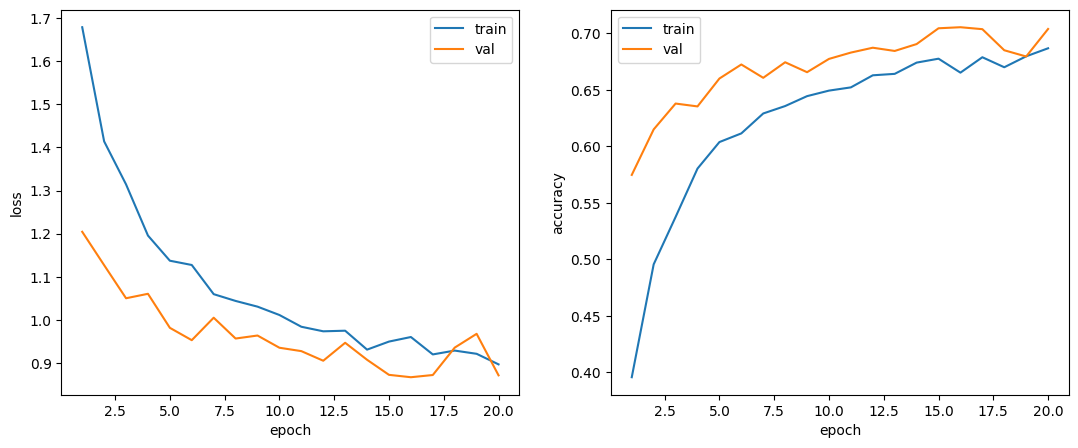

In [25]:
plot_losses(train_losses, train_accs, val_loss_log, val_acc_log)


## 3. Расписание длины шага (2 балла)

С курса "Машинное обучение 1" вы уже должны знать, что сходимость стохастического градиентного спуска мы можем теоретически гарантировать только если будем определенным образом со временем уменьшать длину шага. На практике при обучении нейронных сетей такая техника оказывается очень полезной, однако теоретически обоснованными способами уменьшения длины шага фантазия не ограничивается.

Одним из простейших способов является кусочно постоянная функция: на нескольких фиксированных эпохах уменьшаем длину шага в константу раз.

In [27]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.469333851577159, train acc: 0.4746425307646966
 val loss: 1.306266861519915, val acc: 0.5343306739279564

Epoch 1
 train loss: 1.1518441128120562, train acc: 0.5972716441102176
 val loss: 1.1557731430581275, val acc: 0.5980718085106383

Epoch 2
 train loss: 1.0497366314178411, train acc: 0.6349161009030106
 val loss: 1.364073229343333, val acc: 0.5464982269926274

Epoch 3
 train loss: 0.989399917709762, train acc: 0.6529813594094578
 val loss: 0.9915496448253064, val acc: 0.6601063829787234

Epoch 4
 train loss: 0.9489894500598175, train acc: 0.6699448289993258
 val loss: 0.9822149152451373, val acc: 0.6591533688788719

Epoch 5
 train loss: 0.9177695518219928, train acc: 0.6827337425849119
 val loss: 0.9930264779861937, val acc: 0.6621010638297873

Epoch 6
 train loss: 0.897251108119867, train acc: 0.6878999085923218
 val loss: 0.9339426801559773, val acc: 0.6783244680851064

Epoch 7
 train loss: 0.88117410419628, train acc: 0.6914011491717978
 val loss: 0.925966

Посчитайте точность на тестовой выборке:

In [28]:
# <your code here>
test(net, test_loader)

(0.8220775281168093, 0.7179538216560509)

**Задание 3.0 (0.5 баллов).** Здесь может возникнуть вопрос: а что будет, если мы не будем уменьшать длину шага в процессе обучения, а сразу возьмем констатную, равную значению нашей кусочно-постоянной функции на последних эпохах, то есть $0.001$ в нашем случае. Запустите обучение и проверьте, что в таком случае мы получим худшее качество на тестовой выборке.

In [29]:
# <your code here>
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

Epoch 0
 train loss: 1.8587577988068409, train acc: 0.3467207495429616
 val loss: 1.638524952847907, val acc: 0.4319148936170213

Epoch 1
 train loss: 1.5725996023558175, train acc: 0.44763645862094664
 val loss: 1.4883922627631654, val acc: 0.47788120571603165

Epoch 2
 train loss: 1.4449266711798185, train acc: 0.49226707372630535
 val loss: 1.4081355906547384, val acc: 0.5047650710065315

Epoch 3
 train loss: 1.3608318283963248, train acc: 0.5224887373460494
 val loss: 1.3144354211523177, val acc: 0.5402039007937655

Epoch 4
 train loss: 1.2995769539524475, train acc: 0.5455977410023566
 val loss: 1.2577203732855777, val acc: 0.564516844013904

Epoch 5
 train loss: 1.245686671633607, train acc: 0.5635038522741258
 val loss: 1.2148071885108949, val acc: 0.5783687944107867

Epoch 6
 train loss: 1.2046702348336005, train acc: 0.581613998526411
 val loss: 1.2027916167644743, val acc: 0.5801640071767442

Epoch 7
 train loss: 1.160368850941632, train acc: 0.5960719183332523
 val loss: 1.1

In [30]:
test(net, test_loader)

(0.9370032928551838, 0.6754578025477707)

**Задание 3.1 (1.5 балла).** Изучите, какие еще способы уменьшения длины шага представлены в <code>torch.optim.lr_scheduler</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними. Удалось ли добиться улучшения качества на тестовой выборке?

[torch.optim.lr_scheduler.ExponentialLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ExponentialLR.html#torch.optim.lr_scheduler.ExponentialLR):  Снижает скорость обучения каждой группы параметров по гамме каждую эпоху. Когда last_epoch=-1, устанавливает начальный lr как lr.

$$lr_{epoch} = 𝐺𝑎𝑚𝑚𝑎 * lr_{epoch - 1}$$

In [31]:
# <your code here>
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.4739189907445331, train acc: 0.47423038001034334
 val loss: 1.3131545003424299, val acc: 0.5455895390916378

Epoch 1
 train loss: 1.0999037733461565, train acc: 0.6170752807988545
 val loss: 1.100554889313718, val acc: 0.6150265957446809

Epoch 2
 train loss: 1.04336554454929, train acc: 0.6362137634313957
 val loss: 1.057020444565631, val acc: 0.6333333335024245

Epoch 3
 train loss: 1.0368588916562376, train acc: 0.6366708018226205
 val loss: 1.0552467381700557, val acc: 0.6341976952045522

Epoch 4
 train loss: 1.034284079859418, train acc: 0.6394660812845178
 val loss: 1.0556243931993525, val acc: 0.633222517815042

Epoch 5
 train loss: 1.03435561120837, train acc: 0.6386091343009712
 val loss: 1.055533228021987, val acc: 0.633754432708659

Epoch 6
 train loss: 1.035943725863148, train acc: 0.6384050993204553
 val loss: 1.0557216717841778, val acc: 0.6333554965384462

Epoch 7
 train loss: 1.0360101984449452, train acc: 0.6374134892083609
 val loss: 1.055541797

In [32]:
test_loss, test_acc = test(net, test_loader)
test_loss, test_acc

(1.0624074814425912, 0.626890923566879)

При использовании ExponentialLR качество ухудшилось, хуже чем вообще без scheduler


[torch.optim.lr_scheduler.PolynomialLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.PolynomialLR.html#torch.optim.lr_scheduler.PolynomialLR): Уменьшает lr для каждой группы параметров, используя полиномиальную функцию в заданном total_iters.

Когда last_epoch=-1, задает начальное значение lr как lr.

In [33]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.PolynomialLR(optimizer, total_iters=20)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.5031307156604647, train acc: 0.46274320974646366
 val loss: 1.3229766632648225, val acc: 0.537455673801138

Epoch 1
 train loss: 1.2181320720006605, train acc: 0.5703390246117572
 val loss: 1.1360592507301492, val acc: 0.6065381206096487

Epoch 2
 train loss: 1.0952111753946685, train acc: 0.6197481392942356
 val loss: 1.062204312263651, val acc: 0.6249335106382978

Epoch 3
 train loss: 1.0228337477722378, train acc: 0.6454728715380541
 val loss: 1.062105966628866, val acc: 0.6299423759287976

Epoch 4
 train loss: 0.9741589030356468, train acc: 0.6580373466123829
 val loss: 0.9916083942068384, val acc: 0.6537012412192974

Epoch 5
 train loss: 0.9368878876487341, train acc: 0.6757312614259597
 val loss: 0.9891235014225574, val acc: 0.6579122340425532

Epoch 6
 train loss: 0.9068996537973938, train acc: 0.6854555694015196
 val loss: 0.9720600605010986, val acc: 0.6627659574468086

Epoch 7
 train loss: 0.8828632470894557, train acc: 0.6939311831699211
 val loss: 0.9

In [34]:
test(net, test_loader)

(0.8305980477743088, 0.7120820063694268)

Пока лучше всех, кроме MultiStepLR, но результат довольно сравнимое с MultiStepLR.

[torch.optim.lr_scheduler.CyclicLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CyclicLR.html#torch.optim.lr_scheduler.CyclicLR): Устанавливает lr  в соответствии с политикой циклической скорости обучения (cyclical learning rate policy).
Политика регулирует lr между двумя границами с постоянной частотой.

Этот класс имеет три встроенных политики: “triangular”, “triangular2,
 "exp_range”. По дефолту- “triangular”: Базовый треугольный цикл-сначала постоянно возрастает, а потом убывает.

In [36]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.2)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.8221169381080642, train acc: 0.35725711675623
 val loss: 1.6080144598128947, val acc: 0.43377659574468086

Epoch 1
 train loss: 1.517293324418216, train acc: 0.46643216246006913
 val loss: 1.4254622215920307, val acc: 0.49829343975858487

Epoch 2
 train loss: 1.3984817839627728, train acc: 0.5068596566616944
 val loss: 1.3388470883065082, val acc: 0.5292109929500742

Epoch 3
 train loss: 1.3177644572266713, train acc: 0.5399663751260454
 val loss: 1.2720011335738162, val acc: 0.5530585106382979

Epoch 4
 train loss: 1.2495892791033227, train acc: 0.5643036694587693
 val loss: 1.2267354414818135, val acc: 0.568062943346957

Epoch 5
 train loss: 1.1942365189139106, train acc: 0.5824709455099577
 val loss: 1.1505051602708531, val acc: 0.5999778369639782

Epoch 6
 train loss: 1.1376425596652127, train acc: 0.6035518413052045
 val loss: 1.118107733067046, val acc: 0.6104388297872341

Epoch 7
 train loss: 1.097648557078032, train acc: 0.6180301645338209
 val loss: 1.10

In [37]:
test(net, test_loader)

(0.9127425224917709, 0.6875)

При использовании CyclicLR(“triangular”) качество не удалось улучшить.

## 4. Аугментации данных (2 балла)

Еще одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки, тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.

Простейшая аугментация, которую можно применить к картинкам — разворот картинки по горизонтальной оси. То есть при обучении модели с вероятностью $0.5$ мы будем разворачивать картинку из обучающей выборки.

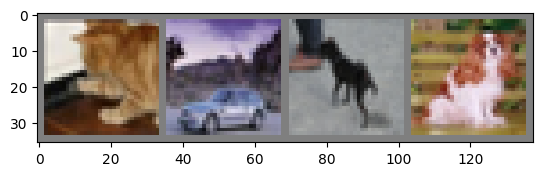

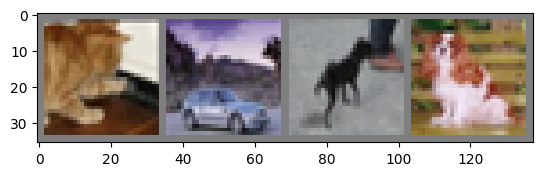

In [39]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

imshow(torchvision.utils.make_grid(transforms.functional.hflip(images[:4])))

Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке <code>transforms</code>, который затем передается в загрузчик данных. Обучим нашу сеть, применяя горизонтальные повороты:

In [40]:
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.4854470428208764, train acc: 0.47007214685244797
 val loss: 1.2978867754023127, val acc: 0.5353058510638298

Epoch 1
 train loss: 1.1930819816301683, train acc: 0.5790839645282878
 val loss: 1.1466849808997297, val acc: 0.5992907801841167

Epoch 2
 train loss: 1.0641718191900027, train acc: 0.628187026685509
 val loss: 1.0693118453025818, val acc: 0.6333333335024245

Epoch 3
 train loss: 1.000170957235793, train acc: 0.6506880060846234
 val loss: 0.9912174894454632, val acc: 0.6588652483960415

Epoch 4
 train loss: 0.9562927338497295, train acc: 0.6683615173674589
 val loss: 0.993888141500189, val acc: 0.6553413122258288

Epoch 5
 train loss: 0.9209189772387963, train acc: 0.6800159963436929
 val loss: 0.9299064983712866, val acc: 0.6726507093044037

Epoch 6
 train loss: 0.9070361798707485, train acc: 0.687793810472192
 val loss: 0.9571355360619566, val acc: 0.6675975178150421

Epoch 7
 t

Посчитайте точность на тестовой выборке:

In [41]:
# <your code here>
test(net, test_loader)

(0.7908877354518623, 0.7298964968152867)

**Задание 4.1 (2 балла).** Изучите, какие еще способы аугментаций изображений представлены в <code>torchvision.transforms</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними (по отдельности и вместе). Удалось ли добиться улучшения качества на тестовой выборке?

transforms.RandomRotation: Повернить вход на указанный угол.

In [42]:
# <your code here>

transform = transforms.Compose(
        [transforms.RandomRotation(degrees = 90),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.7858094406302276, train acc: 0.3609501502631569
 val loss: 1.6584999885964902, val acc: 0.4057845744680851

Epoch 1
 train loss: 1.6188120709040918, train acc: 0.42208311571935414
 val loss: 1.5641619499693526, val acc: 0.4368794327086591

Epoch 2
 train loss: 1.535197303543579, train acc: 0.4552061569756084
 val loss: 1.5077519817555205, val acc: 0.4607712765957447

Epoch 3
 train loss: 1.4795211263722867, train acc: 0.4754423479493401
 val loss: 1.4591134497459899, val acc: 0.4818040780564572

Epoch 4
 train loss: 1.436474242201671, train acc: 0.4884720227836037
 val loss: 1.445006746434151, val acc: 0.49151152486496785

Epoch 5
 train loss: 1.4077714666370065, train acc: 0.5043377840322811
 val loss: 1.381541844631763, val acc: 0.5094193263256803

Epoch 6
 train loss: 1.382043414839443, train acc: 0.5117768999972335
 val loss: 1.4080961998472823, val acc: 0.5032358156873825

Epoch 7
 t

In [43]:
test(net, test_loader)

(1.1558146100894662, 0.5997213375796179)

-> Качество ухудшилось

transforms.ColorJitter: Произвольно изменять яркость, контрастность, насыщенность и оттенок изображения.

In [44]:
transform = transforms.Compose(
        [transforms.ColorJitter(0.1, 0.1, 0.1),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.4842825408827451, train acc: 0.4729000718981518
 val loss: 1.324833581549056, val acc: 0.5266400710065314

Epoch 1
 train loss: 1.1717564434194478, train acc: 0.5907792504570384
 val loss: 1.087915209760057, val acc: 0.6212101063829787

Epoch 2
 train loss: 1.0535400628607714, train acc: 0.6338632803076582
 val loss: 1.0167705360879289, val acc: 0.6473625888215735

Epoch 3
 train loss: 0.9867819055124872, train acc: 0.658159767578899
 val loss: 0.982998505805401, val acc: 0.6594858156873825

Epoch 4
 train loss: 0.9511156093049965, train acc: 0.6689246539877799
 val loss: 0.9815203030058678, val acc: 0.6570257093044037

Epoch 5
 train loss: 0.9191412749194576, train acc: 0.6804893575813042
 val loss: 0.964594939414491, val acc: 0.6653368795171697

Epoch 6
 train loss: 0.894184794297384, train acc: 0.6900218726294132
 val loss: 0.9157478089028216, val acc: 0.6813164893617021

Epoch 7
 trai

In [ ]:
test(net, test_loader)

-> Качество сравнимое с тестовой

transforms.GaussianBlur: Размывает изображение с помощью случайно выбранного размытия по Гауссу

In [46]:
transform = transforms.Compose(
        [transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 5.)),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.5676340588268023, train acc: 0.441772492864668
 val loss: 1.406966521384868, val acc: 0.493594858240574

Epoch 1
 train loss: 1.3093858971456287, train acc: 0.5366079590438271
 val loss: 1.2706543785460451, val acc: 0.5464095744680851

Epoch 2
 train loss: 1.2199978631200912, train acc: 0.5711674066958523
 val loss: 1.197053966116398, val acc: 0.5800310284533399

Epoch 3
 train loss: 1.1632193675642692, train acc: 0.5910404153454238
 val loss: 1.160570034574955, val acc: 0.5955452127659574

Epoch 4
 train loss: 1.121275317843261, train acc: 0.6075876534965836
 val loss: 1.130894289625452, val acc: 0.604654255319149

Epoch 5
 train loss: 1.0882408782376667, train acc: 0.6200827566099777
 val loss: 1.1409366698975258, val acc: 0.6058732271194458

Epoch 6
 train loss: 1.0680494256167787, train acc: 0.6287256790907335
 val loss: 1.1175973402692916, val acc: 0.6096631207364671

Epoch 7
 train 

In [47]:
test(net, test_loader)

(1.033256890667472, 0.6666003184713376)

-> Качество ухудшилось

Выберем вместе 2 лучших способов аугментаций, которые мы смотрели:ColorJitter и GaussianBlur чтобы узнать что будет:

In [48]:
transform = transforms.Compose(
        [transforms.ColorJitter(0.1, 0.1, 0.1),
         transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 5.)),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.5677750529057366, train acc: 0.4403320058390253
 val loss: 1.402199762425524, val acc: 0.4935505319148936

Epoch 1
 train loss: 1.3273872489031315, train acc: 0.5303277618488402
 val loss: 1.2569062958372401, val acc: 0.5589982269926274

Epoch 2
 train loss: 1.2253207768121193, train acc: 0.5688291656251799
 val loss: 1.1954953221564597, val acc: 0.5865469859001484

Epoch 3
 train loss: 1.1587809146649224, train acc: 0.5944192348494173
 val loss: 1.1304609904897973, val acc: 0.6074246454746165

Epoch 4
 train loss: 1.1115499859100286, train acc: 0.6113541395398338
 val loss: 1.1237755985970193, val acc: 0.605252659574468

Epoch 5
 train loss: 1.0765024145734812, train acc: 0.6252774876258055
 val loss: 1.094687144299771, val acc: 0.6177748227373082

Epoch 6
 train loss: 1.0534009941099332, train acc: 0.6323656633741459
 val loss: 1.0428873937180703, val acc: 0.6343528369639783

Epoch 7
 t

In [49]:
test(net, test_loader)

(0.9846030587603332, 0.6761544585987261)

Не можем добиться улучшения качества, но результат лучше, чем просто GaussianBlur, но хуже, чем ColorJitter.

## Бонус. Логирование в wandb (2 балла)

На практике специалиста по глубинному обучению часто встречаются ситуации, когда нейросеть учится на каком-то удаленном сервере. И обычно вам хочется отслеживать прогресс обучения, особенно когда время обучения модели исчисляется днями или неделями. Для таких целей существует несколько инструментов. Вероятно, самый популярный из них — [wandb](https://wandb.ai/site).

Ваша задача состоит в том, чтобы разобраться как им пользоваться, и повторить задания 2.1 и 2.2 с его использованием. Обучение вы можете запускать в этом же ноутбуке, но теперь вам необходимо через wandb логировать значения функции потерь и точности на обучающей выборке и на валидационной. Результатом работы должны быть ваш код и публичная ссылка на страничку с графиками, идентичными графикам в задании 2.2.

In [50]:
# <your code here>
import wandb


In [52]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [53]:
# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="hse-hw2-cnn",

    # track hyperparameters and run metadata
    config={
    "architecture": "CNN",
    "dataset": "CIFAR-10",
    "epochs": 20,
    }
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: minhle12 (minhle12-hse-university). Use `wandb login --relogin` to force relogin


In [54]:
def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()

    criterion = nn.CrossEntropyLoss()

    for data, target in loader:

        # <your code here>
        data = data.to(device)
        target = target.to(device)
        with torch.no_grad():
          logits = model(data)
          loss = criterion(logits, target)

        acc = (logits.argmax(dim=1) == target).sum() / data.shape[0]

        loss_log.append(loss.item())
        acc_log.append(acc.item())

    return np.mean(loss_log), np.mean(acc_log)

def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()

    criterion = nn.CrossEntropyLoss()

    for data, target in train_loader:
      data = data.to(device)
      target = target.to(device)

      optimizer.zero_grad()
      logits = model(data)
      loss = criterion(logits, target)
      loss.backward()
      optimizer.step()

      acc = (logits.argmax(dim=1) == target).sum() / data.shape[0]

      loss_log.append(loss.item())
      acc_log.append(acc.item())

    return loss_log, acc_log

def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []
    train_loss_epochs, train_acc_epochs = [], []
    run = wandb.init(project='hse-hw2-cnn')

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)

        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)
        train_loss_epochs.append(np.mean(train_loss))
        train_acc_epochs.append(np.mean(train_acc))

        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        wandb.log({"Accuracy": wandb.plot.line_series(
                xs=list(range(epoch + 1)),
                ys=[train_acc_epochs, val_acc_log],
                keys=["train", "val"],
                title="Accuracy",
                xname="epoch")})

        wandb.log({"Loss": wandb.plot.line_series(
                xs=list(range(epoch + 1)),
                ys=[train_loss_epochs, val_loss_log],
                keys=["train", "val"],
                title="Loss",
                xname="epoch")})

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")

        if scheduler is not None:
            scheduler.step()

    run.finish()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

In [55]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

Epoch 0
 train loss: 1.6113075059336326, train acc: 0.4213649125487103
 val loss: 1.4134569046345162, val acc: 0.49488031914893615

Epoch 1
 train loss: 1.3787035920284347, train acc: 0.5070840950639853
 val loss: 1.2603602422044633, val acc: 0.5502437944107867

Epoch 2
 train loss: 1.2592896799500726, train acc: 0.5540692739774365
 val loss: 1.2234389819997422, val acc: 0.5652703901554675

Epoch 3
 train loss: 1.2124962763115084, train acc: 0.5697881301534677
 val loss: 1.1864510665548609, val acc: 0.5814273050490846

Epoch 4
 train loss: 1.1654153432445074, train acc: 0.5890408723838151
 val loss: 1.1742364069248767, val acc: 0.5909796100981692

Epoch 5
 train loss: 1.1307679508460287, train acc: 0.6042863672132683
 val loss: 1.1491284857404993, val acc: 0.5995124114320634

Epoch 6
 train loss: 1.107713680380659, train acc: 0.6111419430816414
 val loss: 1.1425831891120748, val acc: 0.6026374114320633

Epoch 7
 train loss: 1.0937612515480906, train acc: 0.6163978845807273
 val loss: 1

Тут все графики:

https://api.wandb.ai/links/minhle12-hse-university/nl7e6kq4

https://api.wandb.ai/links/minhle12-hse-university/s1c3izlq